**AVISO: Este é o terceiro módulo e deve utilizar o kernel do LeituraFicheiros_PBD-grupo12.ipynb**

https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine

# Modelos

Nesta fase do trabalho vamos utilizar modelos de aprendizagem supervisionada para prever se os jogadores respondem às questões corretamente ou não. Para isso, vamos dividir o nosso dataset de Games, onde treinamos o modelo no conjunto de treino e testamos para o conjunto de teste criado.

Por este efeito, <u>não foi utilizado o ficheiro de sample_submissions disponibilizado</u>, pelo que os resultados não serão semelhantes aos pedidos no concurso (resultados de score).

Como já dito em outros módulos, continuamos a utilizar a pipeline de machine learning, tal como mostra a figura seguinte:

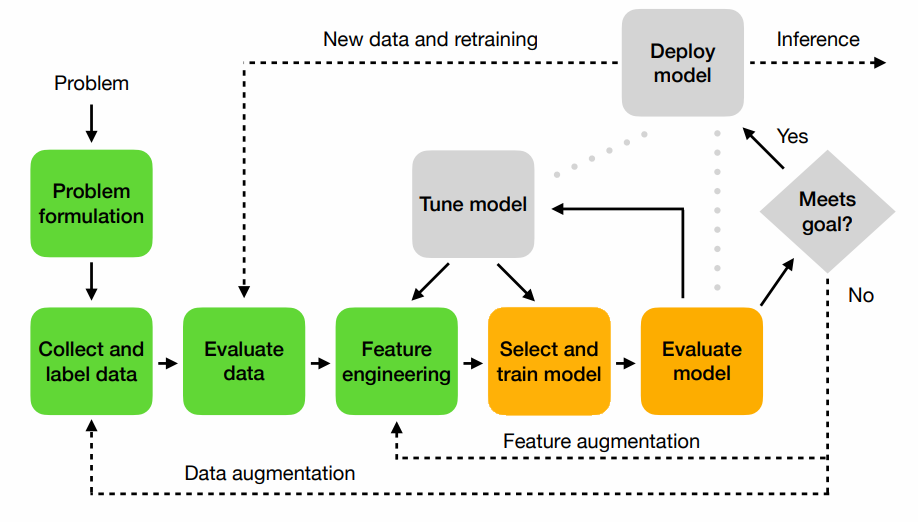

## Leitura do parquet do ficheiro Games

Vai ser lido o ficheiro de perguntas com respostas criado na fase de feature engineering.

In [157]:
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, TimestampType, DoubleType, ArrayType, LongType
schema = StructType([StructField("session_id", LongType(),True),
                             StructField("level_group", StringType(),True),
                             StructField("question", IntegerType(),True),
                             StructField("correct", IntegerType(),True),
                             StructField("ProbCorrect", DoubleType(),True),
                             StructField("mean_screen_coor_x", DoubleType(),True),
                             StructField("mean_screen_coor_y", DoubleType(),True),
                             StructField("mean_room_coor_x", DoubleType(),True),
                             StructField("mean_room_coor_y", DoubleType(),True),
                             StructField("fullscreen", DoubleType(),True),
                             StructField("hq", DoubleType(),True),
                             StructField("music", DoubleType(),True),
                             StructField("elapsed_time/sec", DoubleType(),True),
                             StructField("TextCountDistinct", LongType(),True),
                             StructField("navigate_click", LongType(),True),
                             StructField("object_click", LongType(),True),
                             StructField("notebook_click", LongType(),True),
                             StructField("observation_click", LongType(),True),
                             StructField("cutscene_click", LongType(),True),
                             StructField("notification_click", LongType(),True),
                     		 StructField("person_click", LongType(),True),
                             StructField("map_hover", LongType(),True),
                             StructField("map_click", LongType(),True),
                             StructField("object_hover", LongType(),True),
                             StructField("hover_duration", DoubleType(),True),
                             StructField("ComprimentoTexto", LongType(),True),
                             StructField("NumeroEventos", IntegerType(),True)
                            ])

In [158]:
# read in accordance to the schema above
Games = spark.read.parquet('Games',schema=schema)
Games.printSchema()

root
 |-- session_id: long (nullable = true)
 |-- level_group: string (nullable = true)
 |-- question: integer (nullable = true)
 |-- correct: integer (nullable = true)
 |-- ProbCorrect: double (nullable = true)
 |-- mean_screen_coor_x: double (nullable = true)
 |-- mean_screen_coor_y: double (nullable = true)
 |-- mean_room_coor_x: double (nullable = true)
 |-- mean_room_coor_y: double (nullable = true)
 |-- fullscreen: double (nullable = true)
 |-- hq: double (nullable = true)
 |-- music: double (nullable = true)
 |-- elapsed_time/sec: double (nullable = true)
 |-- TextCountDistinct: long (nullable = true)
 |-- navigate_click: long (nullable = true)
 |-- object_click: long (nullable = true)
 |-- notebook_click: long (nullable = true)
 |-- observation_click: long (nullable = true)
 |-- cutscene_click: long (nullable = true)
 |-- notification_click: long (nullable = true)
 |-- person_click: long (nullable = true)
 |-- map_hover: long (nullable = true)
 |-- map_click: long (nullable = t

Colunas do dataset *Games*, apenas para auxílio.

In [159]:
cols_interest = Games.columns
cols_interest

['session_id',
 'level_group',
 'question',
 'correct',
 'ProbCorrect',
 'mean_screen_coor_x',
 'mean_screen_coor_y',
 'mean_room_coor_x',
 'mean_room_coor_y',
 'fullscreen',
 'hq',
 'music',
 'elapsed_time/sec',
 'TextCountDistinct',
 'navigate_click',
 'object_click',
 'notebook_click',
 'observation_click',
 'cutscene_click',
 'notification_click',
 'person_click',
 'map_hover',
 'map_click',
 'object_hover',
 'hover_duration',
 'ComprimentoTexto',
 'NumeroEventos']

### Criação de uma amostra

Para testar a nível local, sem perder muito tempo, utilizaremos uma amostra do dataset com 10% dos dados de *Games*. Lembrar que mais para a frente, na fase de AWS, este comando vai estar em **raw**, de modo a testar o modelo para a base de dados completa.

In [160]:
###### reduzir o tamanho da base de dados para a visualização dos dados que temos após o feature engineering
small_jogos = Games.sample(withReplacement=False, fraction=0.1, seed=777)
print(f"Existem {small_jogos.count()} linhas na base de dados de amostra.")

Existem 42431 linhas na base de dados de amostra.


## Variáveis a incluir

Seleção das features numéricas e não numéricas e do target do nosso modelo. Como o nosso objetivo é de tentar prever se o player acertou ou não a pergunta, a nossa variável target será a coluna "correct", guardada de uma variável de **"cls_not_features"**. 

Foi estabelecido que as colunas com valores de 0 ou 1 (binários), `fullscreen`, `hq` e `music` , eram variáveis nominais, pois representam "Sim" ou "Não".

In [161]:
cls_not_features = ['correct']
cls_numeric = ['session_id',
 'question',
 'ProbCorrect',
 'mean_screen_coor_x',
 'mean_screen_coor_y',
 'mean_room_coor_x',
 'mean_room_coor_y',
 'elapsed_time/sec',
 'TextCountDistinct',
 'navigate_click',
 'object_click',
 'notebook_click',
 'observation_click',
 'cutscene_click',
 'notification_click',
 'person_click',
 'map_hover',
 'map_click',
 'object_hover',
 'hover_duration',
 'ComprimentoTexto',
 'NumeroEventos']
cls_non_numeric = [i for i in Games.columns if i not in cls_numeric and i not in cls_not_features]
cls_non_numeric

['level_group', 'fullscreen', 'hq', 'music']

Foi retornada uma lista com as variáveis não numéricas utilizadas.

Lembrando que, no chunk de código acima, foram retiradas algumas colunas durante a execução de modelos (na fase abaixo) para ver se teria impacto colocá-las ou não.

## Selecionar e treinar alguns modelos

Passemos então para a fase de modelação dos dados para prever o nosso alvo. Foram realizados os modelos com a ajuda dos imports seguintes:

### Divisão em treino e teste a amostra

In [162]:
# train/test split
df_train, df_test = small_jogos.randomSplit([0.8, 0.2], 42) 
print(f"Existem {df_train.count()} linhas no conjunto de treino e {df_test.count()} no conjunto de teste.")

Existem 34165 linhas no conjunto de treino e 8266 no conjunto de teste.


## 1. Logistic Regression

Numa primeira tentativa, tentámos utilizar um modelo que aos nossos olhos não faz muito sentido. O modelo foi o da regressão logística e a ideia para pensarmos isto foi por este modelo estimar probabilidades. Como os nossos dados globais e de taxa de respostas certas tende para 100%, em algumas perguntas, conseguimos notar que a coluna de `correct` é desbalanceada e, por isso, o modelo de regressão logística irá tender para mais respostas corretas (classe mais desbalanceada).

Com isto, iremos aplicar somente de forma experimental, sabendo que os resultados não serão interessantes.

Inspirado em: https://manishankar.medium.com/scalable-pipeline-pca-and-logistic-regression-using-pyspark-feba21dcdf10

Aqui serão aplicados os métodos de string indexing e one hot encoding para transformação de features.

In [163]:
categorical_cols_lr = [i for i in cls_non_numeric if i not in cls_not_features]
non_categorical_cols_lr = [i for i in cls_numeric if i not in cls_not_features]

index_output_cols_lr = [x + ' Index' for x in categorical_cols_lr]
ohe_output_cols_lr = [x + ' OHE' for x in categorical_cols_lr]

string_indexer_lr = StringIndexer(inputCols=categorical_cols_lr, outputCols=index_output_cols_lr, handleInvalid="skip")
ohe_encoder_lr = OneHotEncoder(inputCols=index_output_cols_lr, outputCols=ohe_output_cols_lr)

assembler_inputs_lr = ohe_output_cols_lr + non_categorical_cols_lr

Criação do vector assembler, que transforma todas as features de entrada num vetor.

In [164]:
vec_assembler_lr = VectorAssembler(inputCols=assembler_inputs_lr, outputCol="features")
pca = PCA(k=2, inputCol='features', outputCol='pcaFeature')

### Logistic regression algorithm

In [165]:
# aplicação do algoritmo
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,labelCol='correct')

#### ML pipeline e treino do modelo

In [166]:
pipeline_lr = Pipeline(stages=[string_indexer_lr, ohe_encoder_lr, vec_assembler_lr, pca, lr])

In [167]:
pipeline_model_lr = pipeline_lr.fit(df_train)

#### Testar e avaliar o modelo

Testar a pipeline criada para o conjunto de teste utilizando o *transform()*.

In [168]:
df_prediction_lr = pipeline_model_lr.transform(df_test)
# df_prediction_lr.printSchema()

In [169]:
df_prediction_lr.select('features', 'rawPrediction', 'prediction', 'correct').show() 

+--------------------+--------------------+----------+-------+
|            features|       rawPrediction|prediction|correct|
+--------------------+--------------------+----------+-------+
|[0.0,1.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      1|
|[1.0,0.0,0.0,1.0,...|[-0.8609246199540...|       1.0|      0|
|[1.0,0.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      0|
|[0.0,0.0,0.0,1.0,...|[-0.8609246199540...|       1.0|      1|
|[1.0,0.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      1|
|[1.0,0.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      1|
|[1.0,0.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      1|
|[1.0,0.0,0.0,1.0,...|[-0.8609246199540...|       1.0|      1|
|[1.0,0.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      1|
|[0.0,1.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      0|
|[1.0,0.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      0|
|[1.0,0.0,1.0,1.0,...|[-0.8609246199540...|       1.0|      0|
|[1.0,0.0,1.0,1.0,...|[-0.8609246199540...|       1.0| 

Será utilizada a área ROC que indica o quão o modelo de classificação binário se desempenha. É relacionada pela taxa de postivos corretamente classificados e da taxa de positivos incorretamente classificados, ou seja, a **sensitivity** do modelo.

In [170]:
# Compute evaluation metrics on test data

prediction_label = df_prediction_lr.select('rawPrediction', 'prediction', 'correct')  

evaluator = BinaryClassificationEvaluator(labelCol='correct')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))

# Matriz de confusão

n = df_prediction_lr.count()
tp = df_prediction_lr.filter(F.expr('prediction == 1') & F.expr('correct == prediction')).count()
tn = df_prediction_lr.filter(F.expr('prediction == 0') & F.expr('correct == prediction')).count()
fp = df_prediction_lr.filter(F.expr('prediction == 1') & F.expr('correct != prediction')).count()
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]

areaUnderROC = 0.5


[5870, 0, 2396, 0, 8266]

In [171]:
display_markdown(f'''
<center>

| **Confusion Matrix** | `Actual Positives` | `Actual Negatives` |
|------------------|-------|------|
|`Predicted Positives`| {tp} | {fp} |
|`Predicted Negatives`| {fn} | {tn} |

<center>
''', raw=True)


<center>

| **Confusion Matrix** | `Actual Positives` | `Actual Negatives` |
|------------------|-------|------|
|`Predicted Positives`| 5870 | 2396 |
|`Predicted Negatives`| 0 | 0 |

<center>


Como podemos observar acima, o valor da curva ROC é 0.5 que indica que o modelo aplicado não é considerado bom, pois é semelhante a aplicar um modelo aleatório (em que prevê aleatoriamente se é correto ou não). Isto consegue ser comprovado ao observar a matriz de confusão acima, indicando que o modelo previu sempre postivos. 

Assim, paramos de analisar este modelo já aqui, antes de calcular as métricas de classificação.

## 2. Linear SVM model

Aplicamos o mesmo processo para o modelo anterior, mas agora para este modelo.

Este modelo tentará produzir os nossos dados num hiperplano que corta os mesmos em duas classificações, que tem o seguinte aspeto:

***imagem apenas ilustrativa***

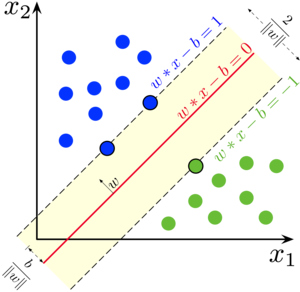

In [172]:
categorical_cols = [i for i in cls_non_numeric if i not in cls_not_features]
non_categorical_cols = [i for i in cls_numeric if i not in cls_not_features]

index_output_cols = [x + ' Index' for x in categorical_cols]
ohe_output_cols = [x + ' OHE' for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
   
# Put all input features into a single vector, by using a transformer

assembler_inputs = ohe_output_cols + non_categorical_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

### Linear SVM algorithm

In [173]:
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol='correct')

#### ML pipeline e treino do modelo

In [174]:
pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, lsvc])

In [175]:
pipeline_model = pipeline.fit(df_train)

#### Testar e avaliar o modelo

In [176]:
df_prediction = pipeline_model.transform(df_test)
# df_prediction.printSchema()

In [177]:
df_prediction.select('features', 'rawPrediction', 'prediction', 'correct').show() 

+--------------------+--------------------+----------+-------+
|            features|       rawPrediction|prediction|correct|
+--------------------+--------------------+----------+-------+
|[0.0,1.0,1.0,1.0,...|[-1.2363407603256...|       1.0|      1|
|[1.0,0.0,0.0,1.0,...|[-1.0401998614323...|       1.0|      0|
|[1.0,0.0,1.0,1.0,...|[-0.1582843049607...|       1.0|      0|
|[0.0,0.0,0.0,1.0,...|[-1.3972981490483...|       1.0|      1|
|[1.0,0.0,1.0,1.0,...|[-1.0205364045580...|       1.0|      1|
|[1.0,0.0,1.0,1.0,...|[-0.5115928834753...|       1.0|      1|
|[1.0,0.0,1.0,1.0,...|[-1.0788105644660...|       1.0|      1|
|[1.0,0.0,0.0,1.0,...|[-0.7920174527263...|       1.0|      1|
|[1.0,0.0,1.0,1.0,...|[-1.0078072245620...|       1.0|      1|
|[0.0,1.0,1.0,1.0,...|[-0.4339448019215...|       1.0|      0|
|[1.0,0.0,1.0,1.0,...|[-0.9545176238616...|       1.0|      0|
|[1.0,0.0,1.0,1.0,...|[0.22110794981736...|       0.0|      0|
|[1.0,0.0,1.0,1.0,...|[-0.4732758861399...|       1.0| 

In [178]:
# Compute evaluation metrics on test data

prediction_label = df_prediction.select('rawPrediction', 'prediction', 'correct')  

evaluator = BinaryClassificationEvaluator(labelCol='correct')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))

# Matriz de confusão

n = df_prediction.count()
tp = df_prediction.filter(F.expr('prediction == 1') & F.expr('correct == prediction')).count()
tn = df_prediction.filter(F.expr('prediction == 0') & F.expr('correct == prediction')).count()
fp = df_prediction.filter(F.expr('prediction == 1') & F.expr('correct != prediction')).count()
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]

areaUnderROC = 0.7549734011541098


[5701, 382, 2014, 169, 8266]

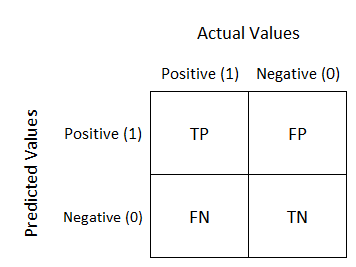

In [179]:
display_markdown(f'''
<center>

| **Confusion Matrix** | `Actual Positives` | `Actual Negatives` |
|------------------|-------|------|
|`Predicted Positives`| {tp} | {fp} |
|`Predicted Negatives`| {fn} | {tn} |

<center>
''', raw=True)


<center>

| **Confusion Matrix** | `Actual Positives` | `Actual Negatives` |
|------------------|-------|------|
|`Predicted Positives`| 5701 | 2014 |
|`Predicted Negatives`| 169 | 382 |

<center>


A área da curva ROC está igualmente próxima de 0.5 (de um modelo aleatório), como de 1 (modelo perfeito), pelo que o modelo considera-se razoável.

##### Métricas de classificação

Serão calculados os valores das métricas de classificação do modelo, utilizando as operações da matriz de confusão seguintes:
Métrica| Significado
:-:|-
`accuracy` |Soma dos elementos da diagonal da matriz sobre o total de observações
`precision` |Mede a proporção de casos positivos que foram corretamente identificados em relação a todos os casos que o modelo identificou como positivos
`recall` |Mede a capacidade do modelo de identificar todos os casos positivos corretamente
`specificity` |Mede a capacidade do modelo de identificar corretamente todos os casos negativos
`f1_score`|É a média harmônica (ao contrário da média simples, esta penaliza valores extremos) do precision e do recall e varia de 0 a 1

In [180]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * recall * precision / (recall + precision)

##### Conclusão sobre o modelo

In [181]:
# Confusion matrix conclusions

print("TP = {}, TN = {}, FP = {}, FN = {}, Total = {}".format(tp, tn, fp, fn, n)) 
print("Accuracy = {}".format(accuracy))
print("Precison = {}".format(precision))
print("Recall = {}".format(recall))
print("Specificity = {}".format(specificity))
print("F1-score = {}".format(f1_score))

TP = 5701, TN = 382, FP = 2014, FN = 169, Total = 8266
Accuracy = 0.7359061214614082
Precison = 0.738950097213221
Recall = 0.9712095400340716
Specificity = 0.15943238731218698
F1-score = 0.8393080603606919


O modelo tem uma boa capacidade preditiva, porém, o modelo prevê muitos casos positivos quando, na verdade, são negativos.

Iremos aplicar mais um modelo diferente para testar o conjunto de dados.

## 3. Gradient-boosted tree classifier

Faremos agora para uma árvore de classificação, através da descida do gradiente (modelo in-built).

In [182]:
Games.columns

['session_id',
 'level_group',
 'question',
 'correct',
 'ProbCorrect',
 'mean_screen_coor_x',
 'mean_screen_coor_y',
 'mean_room_coor_x',
 'mean_room_coor_y',
 'fullscreen',
 'hq',
 'music',
 'elapsed_time/sec',
 'TextCountDistinct',
 'navigate_click',
 'object_click',
 'notebook_click',
 'observation_click',
 'cutscene_click',
 'notification_click',
 'person_click',
 'map_hover',
 'map_click',
 'object_hover',
 'hover_duration',
 'ComprimentoTexto',
 'NumeroEventos']

Teremos de criar um novo string indexer, somente para este modelo, por problemas com o `level_group`.

In [183]:
level_groupIndex = StringIndexer(inputCol="level_group", outputCol="indexedLevel_group").fit(small_jogos)

In [184]:
df = level_groupIndex.transform(small_jogos)

In [185]:
cls = cls_numeric
for i in cls_non_numeric:
    if i != "level_group":
        cls.append(i)
cls.append("indexedLevel_group")
assembler = VectorAssembler(inputCols=cls_numeric, outputCol="features")

df = assembler.transform(df)

### GBT Classifier algorithm

Não foi possível aplicar o algoritmo com o pipeline então decidimos fazer outra vez a divisão em treino e teste e utilizar o dataframe com o assembler transformado no *dataframe* de raiz.

In [186]:
gbt = GBTClassifier(featuresCol="features", labelCol="correct", maxIter=10)

In [187]:
# train/test split de novo, com o assembler transformado

df_train, df_test = df.randomSplit([0.8, 0.2], 42) 

In [188]:
model = gbt.fit(df_train)

#### Testar e avaliar o modelo

In [189]:
# Make predictions on test data and show values of columns of interest

df_prediction = model.transform(df_test)

# df_prediction.printSchema()

**Demorou 4.12 segundos a aplicar o modelo de Gradient boosted Tree Classifier, sem pipeline.**

In [190]:
# Columns to be focus on

df_prediction.select('features', 'rawPrediction', 'prediction', 'correct').show()

+--------------------+--------------------+----------+-------+
|            features|       rawPrediction|prediction|correct|
+--------------------+--------------------+----------+-------+
|[2.01000085722660...|[-0.8355913037895...|       1.0|      1|
|[2.01000161909526...|[-0.7565606299655...|       1.0|      0|
|[2.01000172217803...|[0.34738593409019...|       0.0|      0|
|[2.01001070641527...|[-1.1526905020999...|       1.0|      1|
|[2.01001115006323...|[-0.6935582548610...|       1.0|      1|
|[2.01001131215804...|[-0.2002413134618...|       1.0|      1|
|[2.01001141858677...|[-0.7739128453005...|       1.0|      1|
|[2.01001170309644...|[-0.3212704753942...|       1.0|      1|
|[2.01002102600146...|[-0.7728582178520...|       1.0|      1|
|[2.01002105855495...|[0.15772363886351...|       0.0|      0|
|[2.01002105855495...|[-0.6787076038597...|       1.0|      0|
|[2.01002105855495...|[0.74013148784250...|       0.0|      0|
|[2.01002122837361...|[-0.2322457222263...|       1.0| 

In [191]:
# Compute evaluation metrics on test data

prediction_label = df_prediction.select('rawPrediction', 'prediction', 'correct')  

evaluator = BinaryClassificationEvaluator(labelCol='correct')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))

# Matriz de confusão

n = df_prediction.count()
tp = df_prediction.filter(F.expr('prediction == 1') & F.expr('correct == prediction')).count()
tn = df_prediction.filter(F.expr('prediction == 0') & F.expr('correct == prediction')).count()
fp = df_prediction.filter(F.expr('prediction == 1') & F.expr('correct != prediction')).count()
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]

areaUnderROC = 0.7567523100681715


[5447, 697, 1699, 423, 8266]

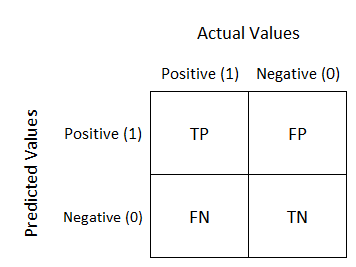

In [192]:
display_markdown(f'''
<center>

| **Confusion Matrix** | `Actual Positives` | `Actual Negatives` |
|------------------|-------|------|
|`Predicted Positives`| {tp} | {fp} |
|`Predicted Negatives`| {fn} | {tn} |

<center>
''', raw=True)


<center>

| **Confusion Matrix** | `Actual Positives` | `Actual Negatives` |
|------------------|-------|------|
|`Predicted Positives`| 5447 | 1699 |
|`Predicted Negatives`| 423 | 697 |

<center>


Vemos que a curva ROC não varia muito face ao modelo anterior (**Linear SVM**) e, por isso, este parâmetro não pode ser levado tão em conta, num caráter de comparação de modelos. No entanto, importante realçar que este modelo tenta de fato prever respostas incorretas/(valores negativos), ainda da grande desproporção das classes de respostas. Pelo que, podemos concluir já que é um modelo talvez melhor que o anterior? Para isso, teremos de ver as métricas.

##### Métricas de classificação

Em semelhança com o modelo anterior serão calculadas as operações da matriz de confusão, relativas às métricas.

In [193]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * recall * precision / (recall + precision)

##### Conclusão sobre o modelo

In [194]:
# Confusion matrix conclusions

print("TP = {}, TN = {}, FP = {}, FN = {}, Total = {}".format(tp, tn, fp, fn, n)) 
print("Accuracy = {}".format(accuracy))
print("Precison = {}".format(precision))
print("Recall = {}".format(recall))
print("Specificity = {}".format(specificity))
print("F1-score = {}".format(f1_score))

TP = 5447, TN = 697, FP = 1699, FN = 423, Total = 8266
Accuracy = 0.7432857488507137
Precison = 0.762244612370557
Recall = 0.92793867120954
Specificity = 0.2909015025041736
F1-score = 0.8369698832206515


Pelo que já foi enunciado e pelos valores das métricas, considera-se este como o nosso melhor modelo. É verdade que os valores não são muito distintos dos obtidos no modelo anterior, contudo, vemos que a **specificity** é maior em relação ao mesmo. Daí conseguimos retirar que o modelo, para além de tentar prever mais casos negativos, também acerta em mais, estando mais próximo de um modelo "perfeito" (comparativamente ao modelo do SVM), onde há bastantes respostas incorretas que devem ser classificadas como negativo.

## 4. Random forest classifier

In [195]:
Games.columns

['session_id',
 'level_group',
 'question',
 'correct',
 'ProbCorrect',
 'mean_screen_coor_x',
 'mean_screen_coor_y',
 'mean_room_coor_x',
 'mean_room_coor_y',
 'fullscreen',
 'hq',
 'music',
 'elapsed_time/sec',
 'TextCountDistinct',
 'navigate_click',
 'object_click',
 'notebook_click',
 'observation_click',
 'cutscene_click',
 'notification_click',
 'person_click',
 'map_hover',
 'map_click',
 'object_hover',
 'hover_duration',
 'ComprimentoTexto',
 'NumeroEventos']

In [196]:
level_groupIndex = StringIndexer(inputCol="level_group", outputCol="indexedLevel_group").fit(small_jogos)

In [197]:
df = level_groupIndex.transform(small_jogos)

In [198]:
cls = cls_numeric
for i in cls_non_numeric:
    if i != "level_group":
        cls.append(i)
cls.append("indexedLevel_group")
assembler = VectorAssembler(inputCols=cls_numeric, outputCol="features")

df = assembler.transform(df)

Teremos de criar um novo string indexer, somente para este modelo, por problemas com o `level_group`.

### Random Forest Algorithm

In [199]:
rf = RandomForestClassifier(labelCol="correct", featuresCol="features", numTrees=10)

Não foi possível aplicar o algoritmo com o pipeline então decidimos fazer outra vez a divisão em treino e teste e utilizar o dataframe com o assembler transformado no dataframe de raiz.

In [200]:
# train/test split de novo, com o assembler transformado

df_train, df_test = df.randomSplit([0.8, 0.2], 42) 

In [201]:
# Treinamento do modelo
model = rf.fit(df_train)

#### Testar e avaliar o modelo

In [202]:
# Make predictions on test data and show values of columns of interest

df_prediction = model.transform(df_test)

# df_prediction.printSchema()

In [203]:
# Columns to be focus on

df_prediction.select('features', 'rawPrediction', 'prediction', 'correct').show()

+--------------------+--------------------+----------+-------+
|            features|       rawPrediction|prediction|correct|
+--------------------+--------------------+----------+-------+
|[2.01000085722660...|[2.75862449990210...|       1.0|      1|
|[2.01000161909526...|[2.50592456882171...|       1.0|      0|
|[2.01000172217803...|[5.09571975825205...|       0.0|      0|
|[2.01001070641527...|[0.80138898998910...|       1.0|      1|
|[2.01001115006323...|[2.77438277509788...|       1.0|      1|
|[2.01001131215804...|[4.08458475786697...|       1.0|      1|
|[2.01001141858677...|[2.68728442706017...|       1.0|      1|
|[2.01001170309644...|[3.42832562183890...|       1.0|      1|
|[2.01002102600146...|[2.50150522578850...|       1.0|      1|
|[2.01002105855495...|[5.13172438808031...|       0.0|      0|
|[2.01002105855495...|[2.56119613768605...|       1.0|      0|
|[2.01002105855495...|[4.69367741012058...|       1.0|      0|
|[2.01002122837361...|[4.14208557894905...|       1.0| 

In [204]:
# Compute evaluation metrics on test data

prediction_label = df_prediction.select('rawPrediction', 'prediction', 'correct')  

evaluator = BinaryClassificationEvaluator(labelCol='correct')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))

# Matriz de confusão

n = df_prediction.count()
tp = df_prediction.filter(F.expr('prediction == 1') & F.expr('correct == prediction')).count()
tn = df_prediction.filter(F.expr('prediction == 0') & F.expr('correct == prediction')).count()
fp = df_prediction.filter(F.expr('prediction == 1') & F.expr('correct != prediction')).count()
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]

areaUnderROC = 0.7493075483557204


[5720, 373, 2023, 150, 8266]

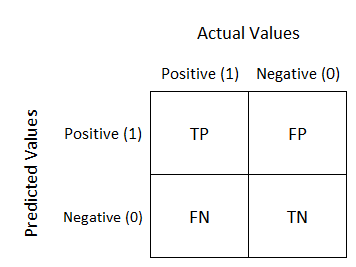

In [205]:
display_markdown(f'''
<center>

| **Confusion Matrix** | `Actual Positives` | `Actual Negatives` |
|------------------|-------|------|
|`Predicted Positives`| {tp} | {fp} |
|`Predicted Negatives`| {fn} | {tn} |

<center>
''', raw=True)


<center>

| **Confusion Matrix** | `Actual Positives` | `Actual Negatives` |
|------------------|-------|------|
|`Predicted Positives`| 5720 | 2023 |
|`Predicted Negatives`| 150 | 373 |

<center>


##### Métricas de classificação

Em semelhança com o modelo anterior serão calculadas as operações da matriz de confusão, relativas às métricas.

In [206]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * recall * precision / (recall + precision)

##### Conclusão sobre o modelo

In [207]:
# Confusion matrix conclusions

print("TP = {}, TN = {}, FP = {}, FN = {}, Total = {}".format(tp, tn, fp, fn, n)) 
print("Accuracy = {}".format(accuracy))
print("Precison = {}".format(precision))
print("Recall = {}".format(recall))
print("Specificity = {}".format(specificity))
print("F1-score = {}".format(f1_score))

TP = 5720, TN = 373, FP = 2023, FN = 150, Total = 8266
Accuracy = 0.7371158964432616
Precison = 0.7387317577166473
Recall = 0.9744463373083475
Specificity = 0.1556761268781302
F1-score = 0.8403731727025637
23/04/09 01:09:09 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-d9b42a40-f4e2-4a33-8db2-6635b49dd658. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-d9b42a40-f4e2-4a33-8db2-6635b49dd658
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:171)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:110)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:91)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1206)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:374)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:370)
	at 

Pelo que já foi enunciado e pelos valores das métricas, considera-mos este como um dos nossos melhores modelos. Apesar de ter tido valores parecidos com o algoritmo Gradient-boosted tree classifier, acredita-mos que o Gradient-boosted tree classifier continua a ser um modelo melhor que este devido, não só à sua maior robustez como modelo, como a capacidade preditora de **TN** é maior, tentando prever mais casos megativos que o random Forest.